In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from environment import Environment
from actor_model import Actor

2023-11-25 20:34:18.892028: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 20:34:18.928400: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 20:34:18.928428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 20:34:18.929273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 20:34:18.934290: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 20:34:18.934663: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
n_samples = 5
n_locations = 10
max_demand = 10
max_capacity = 20
env = Environment(n_samples, n_locations, max_demand, max_capacity)
actor = Actor(n_locations)
optimizer = tf.keras.optimizers.Adam()

with tf.GradientTape(persistent=True) as tape:
    actions = []
    for i in range(20):
        logits = actor(env, training=True) - env.mask * 1000000

        logits_max = tf.nn.softmax(logits * 100)

        action = tf.reduce_sum(env.locations * tf.tile(tf.expand_dims(logits_max, -1), [1, 1, 2]), axis=1)

        env.update(tf.argmax(logits, 1))

        actions.append(action)

    acts = tf.convert_to_tensor(actions)  # shape [n_steps x n_samples x 2]
    acts_shifted = tf.concat((tf.expand_dims(actions[-1], 0), actions[:-1]), 0)

    distances = tf.math.sqrt(tf.reduce_sum(tf.math.square(acts_shifted - acts), -1) + 1e-12)
    summed_path = tf.reduce_sum(distances, axis=0)

    loss = tf.reduce_mean(summed_path * 10000000)

grads = tape.gradient(loss, actor.trainable_variables)
grads_and_vars = zip(grads, actor.trainable_variables)
optimizer.apply_gradients(grads_and_vars)

2023-11-25 20:34:24.180302: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

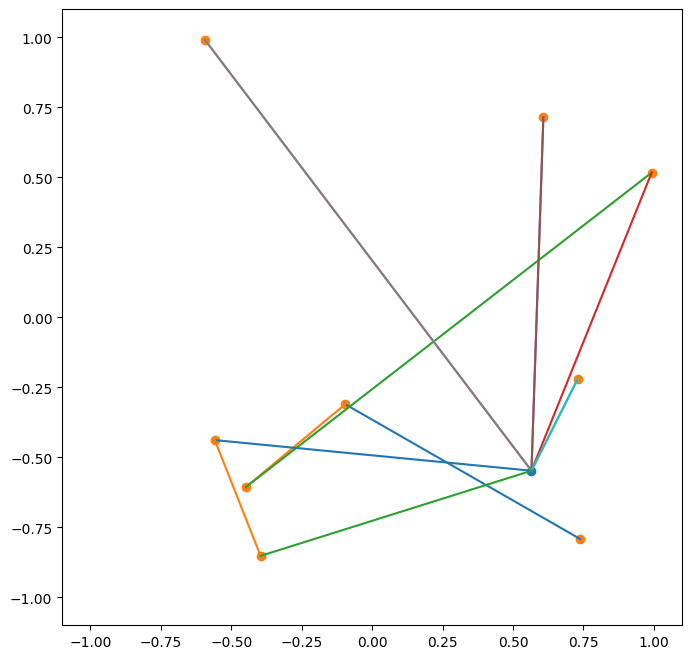

In [11]:
plt.figure(figsize=(8, 8))

sample_id = 0

plt.scatter(env.locations[sample_id, 0, 0], env.locations[sample_id, 0, 1])
plt.scatter(env.locations[sample_id, 1:, 0], env.locations[sample_id, 1:, 1])
for i in range(len(acts) - 1):
    plt.plot([acts[i, sample_id, 0], acts[i + 1, sample_id, 0]], [acts[i, sample_id, 1], acts[i + 1, sample_id, 1]])

plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.show()